In [1]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize, Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from tqdm import tqdm
from IPython.display import Image, display_svg, SVG
import os
from fastai.metrics import RocAuc

In [2]:
valid_pct = 0.2

In [3]:
data = pd.read_csv("archive/Base.csv")
for file in os.listdir("archive")[1:]:
    new = pd.read_csv("archive/" + file)
    data = pd.concat([data, new])
data = data.drop(["x1", "x2"], axis=1) # Drop "velocity_6h", "velocity_4w",
#data.sort_values(month)

In [4]:
valid_data = data[data['month'] >= 6]
train_data = data[data['month'] < 6]

priv_data = valid_data[valid_data["customer_age"] <= 50]
unpriv_data = valid_data[valid_data["customer_age"] > 50]

In [5]:
procs = [Categorify] # Normalizer
dep_var = "fraud_bool"
cont,cat = cont_cat_split(data, 1, dep_var=dep_var)
train = TabularPandas(train_data, procs, cat, cont, y_names=dep_var)
valid = TabularPandas(valid_data, procs, cat, cont, y_names=dep_var)

privileged = TabularPandas(priv_data, procs, cat, cont, y_names=dep_var)
unprivileged = TabularPandas(unpriv_data, procs, cat, cont, y_names=dep_var)

In [8]:
m = rf(train.xs, train.y)

In [ ]:
predictions = discretify(np.stack([t.predict(valid.xs) for t in m.estimators_]).mean(0))
priv_predictions = discretify(np.stack([t.predict(privileged.xs) for t in m.estimators_]).mean(0))
unpriv_predictions = discretify(np.stack([t.predict(unprivileged.xs) for t in m.estimators_]).mean(0))

priv_count = int(torch.sum(tensor(priv_predictions) == 1))
unpriv_count = int(torch.sum(tensor(unpriv_predictions) == 1))

targets = np.array(valid.y)
priv_targets = np.array(privileged.y)
unpriv_targets = np.array(unprivileged.y)

In [227]:
false_positive_rate = fp_rate(predictions, targets)
priv_fpr = fp_rate(priv_predictions, priv_targets)
priv_tpr = tp_rate(priv_predictions, priv_targets)
unpriv_fpr = fp_rate(unpriv_predictions, unpriv_targets)
unpriv_tpr = tp_rate(unpriv_predictions, unpriv_targets)

fairness_score = fairness(priv_fpr, unpriv_fpr)

print("False positive rate (FPR): " + str(int(false_positive_rate * 10000) / 100) + "%")
print("Fairness: Minority group is " + str(int(fairness_score * 10000) / 100) + "% more likely to receive a false positive than the majority group.")

False positive rate (FPR): 1.25%
Fairness: Minority group is 196.25% more likely to receive a false positive than the majority group.


In [275]:
def vertical_annotate(x, y_lower, y_upper, interval, text):
    # Annotation:
    plt.text(x, y_upper, "_")
    for i in range(100):
        if (y_upper - (interval * (i + 1)) < y_lower): break
        plt.text(x, y_upper - (interval * (i + 1)), "|", color="black")
    plt.text(x, y_lower, "_")

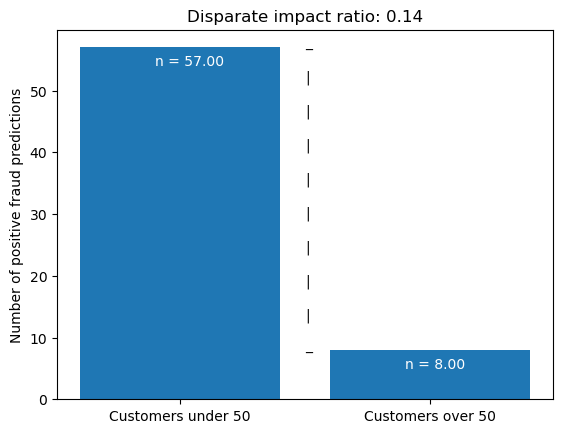

In [218]:
# Disparate impact graph
x = ["Customers under 50", "Customers over 50"]
y = [priv_count, unpriv_count]
for i in range_of(y):
    plt.text(i - 0.1, y[i] - 3, "n = " + "{:.2f}".format(y[i]), color="white")

plt.bar(x, y, width=0.8)
plt.ylabel("Number of positive fraud predictions")
plt.xticks = []

disparate_impact = "{:.2f}".format(unpriv_count / priv_count)
spd = str(priv_count - unpriv_count)

vertical_annotate(0.5, unpriv_count, priv_count, 5.5, "n = " + spd)

plt.title("Disparate impact ratio: " + disparate_impact)

plt.show()
#print("Statistical parity difference: " + str(statistical_parity_difference(min_predictions, maj_predictions)))

In [238]:
print(priv_tpr, unpriv_tpr)

0.8070175438596491 0.75


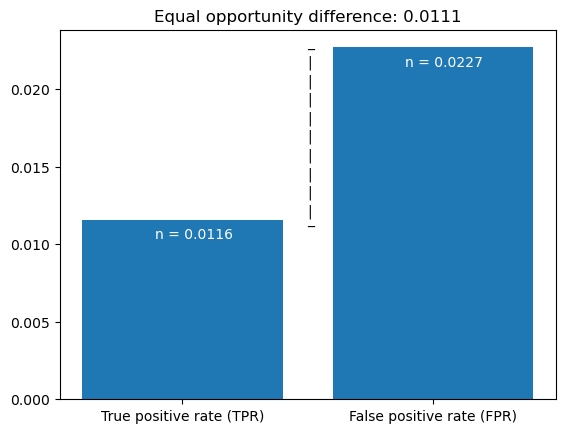

In [242]:
# Equal opportunity difference
x = ["True positive rate (TPR)", "False positive rate (FPR)"]
y = [priv_fpr, unpriv_fpr]
for i in range_of(y):
    plt.text(i - 0.11, y[i] - interval, "n = " + "{:.4f}".format(y[i]), color="white")

interval = 0.0012

vertical_annotate(0.5, priv_fpr - 0.0003, unpriv_fpr, 0.0012, "n = " + spd)
eod = "{:.4f}".format(unpriv_fpr - priv_fpr)

plt.title("Equal opportunity difference: " + eod)
plt.bar(x, y, width=0.8)

plt.show()

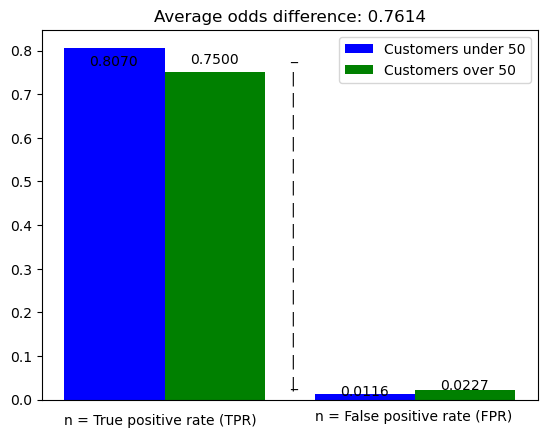

In [338]:
# Equal opportunity difference
fig = plt.figure()
ax = fig.add_subplot(111)

x = ["Customers under 50", "Customers over 50"]
y1 = [priv_tpr, priv_fpr]
y2 = [unpriv_tpr, unpriv_fpr]
ind = np.arange(2)
width = 0.4

offset = -0.10
for i in range_of(y1):
    plt.text(i + offset, 0.95 * (y1[i] - interval), "{:.4f}".format(y1[i]), color="black")
    plt.text(i + offset + width, 1.03 * (y2[i] - interval), "{:.4f}".format(y2[i]), color="black")
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
plt.text(0 - 0.2, y[0] - 0.07, "n = " + "True positive rate (TPR)", color="black")
plt.text(1 - 0.2, y[1] - 0.07, "n = " + "False positive rate (FPR)", color="black")

rects1 = ax.bar(ind, y1, width, color='b')
rects2 = ax.bar(ind+width, y2, width, color='g')

ax.set_xticklabels([])
ax.legend( (rects1[0], rects2[0]), x)

y_lower = (priv_fpr + unpriv_fpr) / 2 + 0.01
y_upper = (priv_tpr + unpriv_tpr) / 2
vertical_annotate(0.7, y_lower, y_upper, 0.05, "n = " + spd)

aod = "{:.4f}".format(average_odds_difference(priv_tpr, priv_fpr, unpriv_tpr, unpriv_fpr))
plt.title("Average odds difference: " + aod)

plt.show()

In [7]:
def discretify(means): return [1 if mean > 0.5 else 0 for mean in means]

def fp_rate(preds, targs):
    return metrics.roc_curve(preds, targs)[0][1]

def tp_rate(preds, targs):
    tpr = metrics.roc_curve(preds, targs)[1][1]
    if (math.isnan(tpr)): raise Exception("tpr is undefined")
    return tpr

def get_accuracy(preds, targets):
    corrects = 0;
    for pred, target in list(zip(preds, targets)):
        if (abs(pred - target) < 0.5): corrects += 1
    return corrects / len(preds)

def fairness(majority_fpr, minority_fpr): 
    return minority_fpr / majority_fpr

def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, 
                                 max_features=max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [339]:
def equal_opportunity_difference(priv_preds, priv_targs, unpriv_preds, unpriv_targs):
    return fp_rate(priv_preds, priv_targs) - fp_rate(unpriv_preds, unpriv_targs)

def average_odds_difference(priv_tpr, priv_fpr, unpriv_tpr, unpriv_fpr):
    return ((priv_tpr - priv_fpr) + (unpriv_tpr - unpriv_fpr)) / 2

#def theil_index()